In [128]:
import os
import numpy as np
import pandas as pd
# import tensorflow as tf
from biom import load_table
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
#from gneiss.util import match
from scipy.spatial import KDTree
from scipy.stats import rankdata
from skbio.stats.composition import clr, clr_inv, centralize
from sklearn.neighbors import NearestNeighbors, KDTree
from skbio.stats.ordination import OrdinationResults
from scipy.spatial.distance import euclidean
from scipy.stats import spearmanr
from src.evaluate import _edge_roc_curve
import datetime
from matplotlib import rc
import matplotlib
%matplotlib inline

# Evaluate True Positive rate of methods

Since we have annotations, we should be able to do this.

In [129]:
# tools = ['mmvec', 'spearman', 'pearson', 'sparcc', 'phi', 'rho', 'spiec-easi']
tools = ['mmvec']
# fnames = [
#     'mmvec_ranks.csv',
#     'soils_spearman.txt',
#     'soils_pearson.txt',
#     'cor_matrix_soil_SparCC.csv',
#     'prop_matrix_soil_PHI.csv',
#     'prop_matrix_soil_RHO.csv',
#     'weights_soil_SPIECEASI.csv'
# ]
fnames = ['mmvec_ranks.csv']

In [130]:
!ls ./results/other_ranks

cor_matrix_soil_SparCC.csv     prop_matrix_soil_RHO.csv
edgelist_soil_SEmultitest.csv  soils_pearson.txt
mmvec_ranks.csv		       soils_spearman.txt
prop_matrix_soil_PHI.csv       weights_soil_SPIECEASI.csv


In [131]:
select_microbes = ['rplo 1 (Cyanobacteria)', 'rplo 2 (Firmicutes)',
                   'rplo 60 (Firmicutes)', 'rplo 7 (Actinobacteria)']
microcoleus_metabolites = ['(3-methyladenine)', '7-methyladenine', '4-guanidinobutanoate', 'uracil',
                           'xanthine', 'hypoxanthine', '(N6-acetyl-lysine)', 'cytosine',
                           'N-acetylornithine', 'N-acetyl-glutamate', 'succinate',
                           'adenosine', 'guanine', 'adenine']

In [132]:
ranks = pd.read_csv(os.path.join('./results/other_ranks', fnames[0]), index_col=0)

In [133]:
sensitivity = lambda x: x['TP'] / (x['TP'] + x['FN'])
specificity = lambda x: x['TN'] / (x['TN'] + x['FP'])
precision = lambda x: x['TP'] / (x['TP'] + x['FP'])
recall = lambda x: x['TP'] / (x['TP'] + x['FN'])
f1 = lambda x: 2 * x['precision'] * x['recall'] / (x['precision'] + x['recall'])

In [134]:
edges = pd.DataFrame(list(zip(['rplo 1 (Cyanobacteria)'] * len(microcoleus_metabolites),
                              microcoleus_metabolites)), columns=['microbe', 'metabolite'])
edges['direction'] = 'R'

microbes = list(ranks.columns)
metabolites = list(ranks.columns)
other_metabolites = list(set(metabolites) - set(microcoleus_metabolites))

other_edges = pd.DataFrame(other_metabolites, columns=['metabolite'])
other_edges['microbe'] = 'rplo 1 (Cyanobacteria)'
other_edges['direction'] = 0

edges = pd.concat((edges, other_edges), axis=0)
edges = edges[['microbe', 'metabolite', 'direction']]

In [135]:
# read ranks from specified other tools
def read_df(fname):
    if '.txt' in fname:
        return pd.read_table(os.path.join('./results/other_ranks', fname),
                             index_col=0)
    else:
        return pd.read_csv(os.path.join('./results/other_ranks', fname),
                           index_col=0)


rankz = list(map(read_df, fnames))

# read ranks from DML
# rankz.append(pd.read_csv(os.path.join('./results/original_data', 'coefficients.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/soil_output', 'dml_ranks_norm.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/original_data_lr', 'coefficients.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/boost_original_data', 'coefficients.tsv'), sep="\t", index_col=0).T)
rankz.append(pd.read_csv(os.path.join('./results/xgboost_original_data', 'coefficients.tsv'), sep="\t", index_col=0).T)
rankz.append(pd.read_csv(os.path.join('./results/xgboost_clr', 'coefficients.tsv'), sep="\t", index_col=0).T)
rankz.append(pd.read_csv(os.path.join('./results/xgboost_clr_sep', 'coefficients.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/soil_output', 'dml_ranks_lr_clr_sc.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/soil_output', 'dml_ranks_boost.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/soil_output', 'dml_ranks_boost_clr_sc.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/clr', 'coefficients.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/clr_sc', 'coefficients.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/clr_min', 'coefficients.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/clr_sc_min', 'coefficients.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/clr_sep', 'coefficients.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/clr_sep_min', 'coefficients.tsv'), sep="\t", index_col=0).T)

# rankz.append(pd.read_csv(os.path.join('./results/automl_rf_short', 'coefficients.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/automl_rf_short_clr', 'coefficients.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/automl_xgboost_short', 'coefficients.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/automl_xgboost_short_clr', 'coefficients.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/automl_rf_long', 'coefficients.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/automl_rf_long_clr', 'coefficients.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/automl_xgboost_long', 'coefficients.tsv'), sep="\t", index_col=0).T)
# rankz.append(pd.read_csv(os.path.join('./results/automl_xgboost_long_clr', 'coefficients.tsv'), sep="\t", index_col=0).T)

In [136]:
def roc_f(ranks, tool):
    r = ranks.T[['rplo 1 (Cyanobacteria)']].loc[metabolites].T
    if tool == 'phi':
        r = 1 / r

    res = _edge_roc_curve(r, edges, k_max=85)
    return res

# Include DML rank names
# tools.append('DML rf')
# tools.append('DML_Norm')
# tools.append('DML lr')
# tools.append('DML lr CLR sc')
# tools.append('DML boost')
# tools.append('DML boost CLR sc')
tools.append('DML xgboost')
tools.append('DML xgboost clr')
tools.append('DML xgboost clr(sep)')
# tools.append('DML CLR')
# tools.append('DML CLR (sc)')
# tools.append('DML CLR (min)')
# tools.append('DML CLR (sc min)')
# tools.append('DML CLR sep')
# tools.append('DML CLR sep (min)')
#
# tools.append('DML automl rf (short)')
# tools.append('DML automl rf clr (short)')
# tools.append('DML automl xgboost (short)')
# tools.append('DML automl xgboost clr (short)')
# tools.append('DML automl rf (long)')
# tools.append('DML automl rf clr (long)')
# tools.append('DML automl xgboost (long)')
# tools.append('DML automl xgboost clr (long)')
rocs = list(map(lambda x: roc_f(x[0], x[1]), zip(rankz, tools)))

In [137]:
for res in rocs:
    for df in res:
        df['TPR'] = df.apply(sensitivity, axis=1)
        df['TNR'] = df.apply(specificity, axis=1)
        df['precision'] = df.apply(precision, axis=1)
        df['recall'] = df.apply(recall, axis=1)
        df['f1_score'] = df.apply(f1, axis=1)

/tmp/ipykernel_8446/1052544215.py:1: RuntimeWarning: invalid value encountered in long_scalars
  sensitivity = lambda x: x['TP'] / (x['TP'] + x['FN'])
/tmp/ipykernel_8446/1052544215.py:4: RuntimeWarning: invalid value encountered in double_scalars
  recall = lambda x: x['TP'] / (x['TP'] + x['FN'])
/tmp/ipykernel_8446/1052544215.py:1: RuntimeWarning: invalid value encountered in long_scalars
  sensitivity = lambda x: x['TP'] / (x['TP'] + x['FN'])
/tmp/ipykernel_8446/1052544215.py:4: RuntimeWarning: invalid value encountered in double_scalars
  recall = lambda x: x['TP'] / (x['TP'] + x['FN'])
/tmp/ipykernel_8446/1052544215.py:5: RuntimeWarning: invalid value encountered in double_scalars
  f1 = lambda x: 2 * x['precision'] * x['recall'] / (x['precision'] + x['recall'])
/tmp/ipykernel_8446/1052544215.py:1: RuntimeWarning: invalid value encountered in long_scalars
  sensitivity = lambda x: x['TP'] / (x['TP'] + x['FN'])
/tmp/ipykernel_8446/1052544215.py:4: RuntimeWarning: invalid value enco

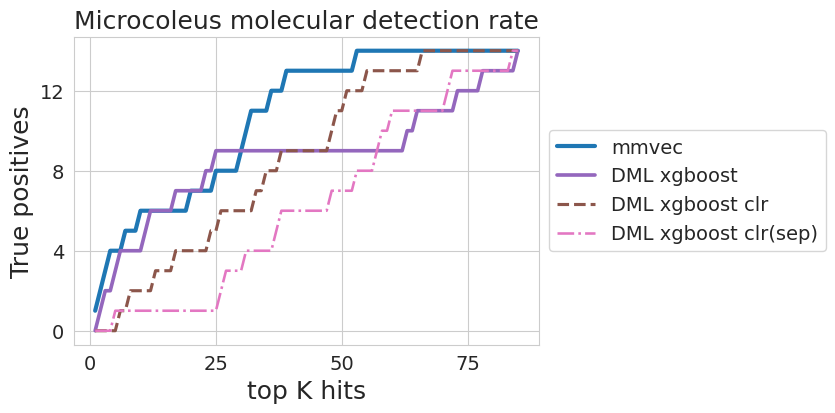

In [138]:
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "b", "g", "r", "y"])
fig, ax = plt.subplots(figsize=(6, 4))
#plt.subplots_adjust(wspace=0.4, hspace=0.5)

for i, (tool, roc) in enumerate(zip(tools, rocs)):
    lw = 3 - 1.5 * i / len(rocs)
    ls = ['-', '-', '--', '-.', ':'][i % 4]
    colors = ["C0", "C4", "C5", "C6"] # colors for xgboost figure
    ax.plot(roc[0]['TP'], label=tool, linewidth=lw, linestyle=ls, color=colors[i])
    ax.set_ylabel('True positives', fontsize=18)
    ax.set_xlabel('top K hits', fontsize=18)
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))

ax.set_title('Microcoleus molecular detection rate', fontsize=18)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)

timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
plt.savefig(f"./figures/biocrust_clr_{timestamp}.png", bbox_inches='tight')

In [139]:
rankings = {}
for i in range(len(rankz)):
    print(tools[i])
    test = rankz[i].T[['rplo 1 (Cyanobacteria)']]
    coeff = test.sort_values('rplo 1 (Cyanobacteria)', ascending=False)
    coeff['rank'] = range(0, coeff.shape[0])
    coeff = coeff.loc[microcoleus_metabolites].sort_values('rank')
    print(coeff)
    rankings[tools[i]] = coeff

mmvec
                      rplo 1 (Cyanobacteria)  rank
adenosine                           5.036277     0
adenine                             4.912609     1
(N6-acetyl-lysine)                  4.389718     2
4-guanidinobutanoate                4.026928     3
cytosine                            3.163511     6
guanine                             3.013095     9
uracil                              1.736077    19
N-acetylornithine                   1.205776    24
(3-methyladenine)                   0.888059    29
succinate                           0.826163    30
xanthine                            0.740586    31
hypoxanthine                        0.645392    35
7-methyladenine                     0.267562    38
N-acetyl-glutamate                 -0.762944    52
DML xgboost
                      rplo 1 (Cyanobacteria)  rank
adenosine                      142024.124739     1
adenine                        141540.572908     2
guanine                         24719.184792     4
(N6-acetyl-ly

In [155]:
table_str = ""
for tool in tools:
    table_str += (tool + " & ")
table_str = table_str[:-2]
table_str += ("\\\ \hline \hline \n")
for i in range(len(rankings[tools[0]])):
    for tool, ranking in rankings.items():
        table_str += (ranking.index[i] + " & ")
    table_str = table_str[:-2]
    table_str += ("\\\ \n")
    for tool, ranking in rankings.items():
        table_str += ("(" + str(ranking['rplo 1 (Cyanobacteria)'][i])[:8] + ")" + " & ")
    table_str = table_str[:-2]
    table_str += ("\\\ \hline \n")

print(table_str)

mmvec & DML xgboost & DML xgboost clr & DML xgboost clr(sep) \\ \hline 
adenosine & adenosine & xanthine & xanthine \\ 
(5.036276) & (142024.1) & (1.038181) & (0.059374) \\ \hline 
adenine & adenine & 7-methyladenine & (3-methyladenine) \\ 
(4.912608) & (141540.5) & (1.033271) & (0.049679) \\ \hline 
(N6-acetyl-lysine) & guanine & hypoxanthine & hypoxanthine \\ 
(4.389717) & (24719.18) & (1.025715) & (0.049665) \\ \hline 
4-guanidinobutanoate & (N6-acetyl-lysine) & guanine & N-acetyl-glutamate \\ 
(4.026928) & (10221.95) & (1.020302) & (0.049421) \\ \hline 
cytosine & uracil & uracil & adenine \\ 
(3.163511) & (3223.999) & (1.015149) & (0.046949) \\ \hline 
guanine & hypoxanthine & (3-methyladenine) & guanine \\ 
(3.013095) & (2992.442) & (1.012911) & (0.046723) \\ \hline 
uracil & (3-methyladenine) & (N6-acetyl-lysine) & N-acetylornithine \\ 
(1.736077) & (1104.676) & (1.011070) & (0.042884) \\ \hline 
N-acetylornithine & N-acetyl-glutamate & 4-guanidinobutanoate & uracil \\ 
(1.20577

/tmp/ipykernel_8446/2283841103.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  table_str += ("(" + str(ranking['rplo 1 (Cyanobacteria)'][i])[:8] + ")" + " & ")
